#### Libraries

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.inspection import permutation_importance
from scipy.stats import zscore
from scipy import stats
import statsmodels.stats.multitest as smm

#### Load the antibody and metadata

In [2]:
gene_data =pd.read_csv("pbmc_gene_expression_raw_count_batchCorrected_data.tsv", sep='\t')
gene_data.head()

,70,71,72,73,74,102,103,104,105,106,...,1467,1474,1476,1477,1484,1486,1487,1494,1496,1497
ENSG00000000419.12,1070,1272,1547,1339,1576,1120,1449,1157,1400,1569,...,416,255,411,451,593,362,549,452,550,633
ENSG00000000457.13,281,291,214,212,243,451,199,113,218,225,...,81,83,106,97,160,128,125,165,114,198
ENSG00000000938.12,8643,8090,5169,5969,5038,5789,10276,11497,5029,6739,...,4075,3634,4812,5577,6264,6817,6325,3086,3402,3941
ENSG00000001036.13,560,590,414,489,374,549,694,764,460,517,...,360,182,270,338,407,501,343,176,226,136
ENSG00000001461.16,1639,1882,815,1510,1185,1734,880,556,964,1131,...,328,696,641,671,366,322,271,737,421,534


In [3]:
metadata =pd.read_csv("subject_specimen.tsv", sep='\t')
metadata


,specimen_id,subject_id,dataset,timepoint,infancy_vac,biological_sex,date_of_boost
0,1,1,2020_dataset,0,wP,Female,2016-09-12
1,2,1,2020_dataset,1,wP,Female,2016-09-12
2,3,1,2020_dataset,3,wP,Female,2016-09-12
3,4,1,2020_dataset,7,wP,Female,2016-09-12
4,5,1,2020_dataset,14,wP,Female,2016-09-12
...,...,...,...,...,...,...,...
891,1486,169,2023_dataset,-14,aP,Male,2023-09-05
892,1487,169,2023_dataset,0,aP,Male,2023-09-05
893,1494,171,2023_dataset,-30,wP,Female,2023-11-13
894,1496,171,2023_dataset,-14,wP,Female,2023-11-13


## 1. Descriptive Statistics

#### (i) Gene Expression Data

In [4]:
gene_data = gene_data.T
gene_data.reset_index(inplace=True)
gene_data.rename(columns={"index": "specimen_id"}, inplace=True)
gene_data.info()
gene_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Columns: 6651 entries, specimen_id to ENSG00000278828.1
dtypes: int64(6650), object(1)
memory usage: 33.8+ MB


,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000938.12,ENSG00000001036.13,ENSG00000001461.16,ENSG00000001497.16,ENSG00000001629.9,ENSG00000001631.15,ENSG00000002549.12,ENSG00000002586.18,...,ENSG00000276085.1,ENSG00000276234.4,ENSG00000276293.4,ENSG00000277443.2,ENSG00000277632.1,ENSG00000277791.4,ENSG00000278053.4,ENSG00000278259.4,ENSG00000278311.4,ENSG00000278828.1
count,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,...,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000,666.000000
mean,682.412913,222.843844,6258.647147,439.070571,894.445946,773.436937,425.117117,333.566066,1582.506006,3483.960961,...,573.819820,179.681682,396.675676,453.435435,813.993994,2117.572072,465.786787,371.387387,2334.648649,833.662162
std,420.717678,153.032975,3948.245075,274.093710,586.472235,446.258224,271.101670,207.253757,1481.188255,2048.614353,...,1311.268333,117.157888,249.040269,464.486813,2849.285864,1287.387422,351.615057,241.810670,1396.397851,691.631308
min,45.000000,5.000000,226.000000,16.000000,55.000000,42.000000,17.000000,13.000000,72.000000,134.000000,...,0.000000,8.000000,15.000000,16.000000,1.000000,41.000000,17.000000,11.000000,118.000000,18.000000
25%,322.000000,100.000000,2922.000000,201.000000,403.000000,360.000000,198.000000,150.250000,631.000000,1578.750000,...,106.000000,81.000000,185.250000,167.000000,122.000000,983.750000,203.250000,168.250000,1076.000000,332.750000
50%,620.000000,189.000000,5723.500000,397.500000,743.000000,804.500000,399.500000,286.500000,1331.000000,3427.000000,...,225.000000,162.000000,359.500000,308.000000,265.000000,2114.500000,357.000000,321.000000,2217.500000,618.000000
75%,986.000000,319.750000,8949.500000,636.250000,1310.750000,1135.000000,603.500000,492.750000,2018.750000,5116.250000,...,489.000000,257.000000,565.000000,553.500000,482.000000,3042.250000,667.000000,542.500000,3453.750000,1150.500000
max,3205.000000,1114.000000,35894.000000,1667.000000,3322.000000,3308.000000,1545.000000,1198.000000,14101.000000,11456.000000,...,11947.000000,992.000000,1632.000000,5229.000000,49934.000000,8239.000000,4557.000000,1823.000000,7751.000000,4091.000000


- Columns - specimen_id (665)
- Rows - gene (6651)

##### Metadata has 896 specimen_id while gene_data has 665 specimen_id. Therefore, checking which specimen ids from metadata matches to columns of gene_data

In [5]:
metadata['specimen_id'] = metadata['specimen_id'].astype(str)
gene_data['specimen_id'] = gene_data['specimen_id'].astype(str)

metadata_ids = set(metadata['specimen_id'])
gene_data_ids = set(gene_data['specimen_id'])

matching_ids = metadata_ids.intersection(gene_data_ids)

 #### (ii) Merging metadata and gene data (specimen_id)

In [6]:
data = pd.merge(metadata, gene_data, on='specimen_id', how='inner')
data

,specimen_id,subject_id,dataset,timepoint,infancy_vac,biological_sex,date_of_boost,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000938.12,...,ENSG00000276085.1,ENSG00000276234.4,ENSG00000276293.4,ENSG00000277443.2,ENSG00000277632.1,ENSG00000277791.4,ENSG00000278053.4,ENSG00000278259.4,ENSG00000278311.4,ENSG00000278828.1
0,1,1,2020_dataset,0,wP,Female,2016-09-12,1165,283,5720,...,791,224,555,562,401,2040,796,636,3604,299
1,2,1,2020_dataset,1,wP,Female,2016-09-12,1013,261,10123,...,1233,169,542,1267,565,3533,579,352,2885,941
2,3,1,2020_dataset,3,wP,Female,2016-09-12,984,259,7263,...,990,203,571,636,492,2266,702,723,3993,505
3,4,1,2020_dataset,7,wP,Female,2016-09-12,1334,408,6555,...,338,297,598,263,235,2859,975,672,3826,855
4,5,1,2020_dataset,14,wP,Female,2016-09-12,1147,319,7060,...,1219,265,631,590,696,2424,816,536,3759,576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,1486,169,2023_dataset,-14,aP,Male,2023-09-05,362,128,6817,...,67,137,207,320,2479,2450,199,160,1838,570
662,1487,169,2023_dataset,0,aP,Male,2023-09-05,549,125,6325,...,149,96,243,112,529,2383,175,166,1184,832
663,1494,171,2023_dataset,-30,wP,Female,2023-11-13,452,165,3086,...,971,174,219,507,419,1471,317,309,1605,623
664,1496,171,2023_dataset,-14,wP,Female,2023-11-13,550,114,3402,...,468,104,230,143,261,1505,251,144,1182,339


#### Sample distribution and outliers

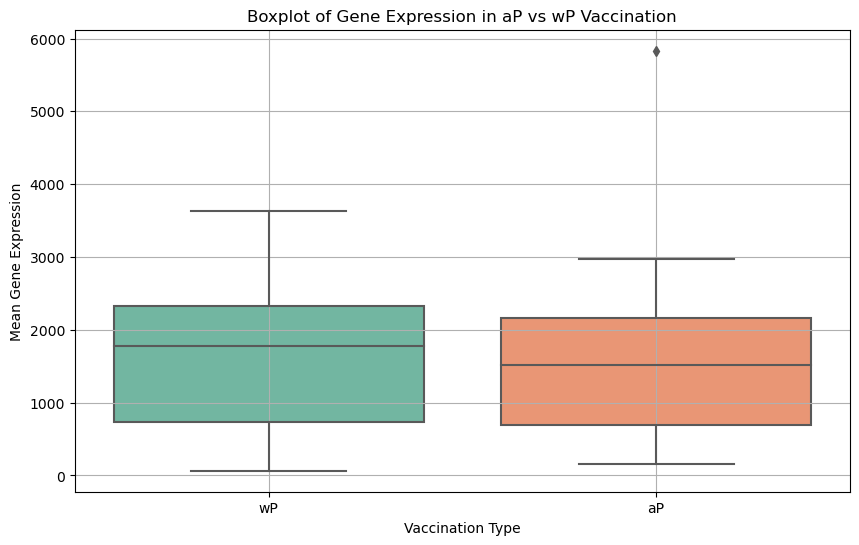

In [9]:
# Identify gene columns (columns starting with 'ENSG')
gene_columns = data.columns[data.columns.str.startswith('ENSG')]
data['Gene Expression'] = data[gene_columns].mean(axis=1)

# Create a boxplot comparing mean expression for different vaccination types
plt.figure(figsize=(10, 6))
sns.boxplot(x='infancy_vac', y='Gene Expression', data=data, palette='Set2')
plt.title('Boxplot of Gene Expression in aP vs wP Vaccination')
plt.xlabel('Vaccination Type')
plt.ylabel('Mean Gene Expression')
plt.grid(True)
plt.show()

#### Z-score normalization
Applied after log transformation, **Z-score normalization** applied to ensure that the data is standardized.

In [13]:
# Make a copy of the DataFrame
data_log2 = data.copy()

# Apply log2 transformation to the selected gene columns
data_log2[gene_columns] = np.log2(data_log2[gene_columns] + 1e-9)

# Verify the transformed DataFrame
print(data_log2[gene_columns].head())

   ENSG00000000419.12  ENSG00000000457.13  ENSG00000000938.12  \
0           10.186114            8.144658           12.481799   
1            9.984418            8.027906           13.305349   
2            9.942515            8.016808           12.826350   
3           10.381543            8.672425           12.678380   
4           10.163650            8.317413           12.785452   

   ENSG00000001036.13  ENSG00000001461.16  ENSG00000001497.16  \
0            8.665336           10.189825           10.055282   
1            9.090112           10.277287            9.965784   
2            8.918863           10.240791           10.111136   
3            9.005625           10.682995           10.391244   
4            8.960002           10.466586           10.048487   

   ENSG00000001629.9  ENSG00000001631.15  ENSG00000002549.12  \
0           9.409391            8.900867           10.419960   
1           9.092757            8.717676           12.183015   
2           9.335390      

#### Z-score normalization
Applied after log transformation, **Z-score normalization** applied to ensure that the data is standardized.

In [15]:
# Make a copy of the DataFrame for normalization
normalized_data = data_log2.copy()

# Select only numeric columns (gene columns)
gene_columns = normalized_data.columns[normalized_data.columns.str.startswith('ENSG')]

# Apply Z-score normalization only to the gene columns
normalized_data[gene_columns] = stats.zscore(normalized_data[gene_columns], axis=0)

# Verify the normalized data
print(normalized_data[gene_columns].head())

   ENSG00000000419.12  ENSG00000000457.13  ENSG00000000938.12  \
0            1.052655            0.647579            0.192346   
1            0.859320            0.541984            0.968489   
2            0.819153            0.531947            0.517063   
3            1.239984            1.124913            0.377611   
4            1.031122            0.803825            0.478520   

   ENSG00000001036.13  ENSG00000001461.16  ENSG00000001497.16  \
0            0.204818            0.689400            0.751622   
1            0.616328            0.771466            0.663464   
2            0.450428            0.737222            0.806638   
3            0.534479            1.152137            1.082550   
4            0.490281            0.949083            0.744928   

   ENSG00000001629.9  ENSG00000001631.15  ENSG00000002549.12  \
0           0.968611            0.807306            0.211314   
1           0.664972            0.634142            1.759291   
2           0.897647      

## Dimensionality Reduction with PCA

Variance by PC1: 0.8149
Variance by PC2: 0.0284


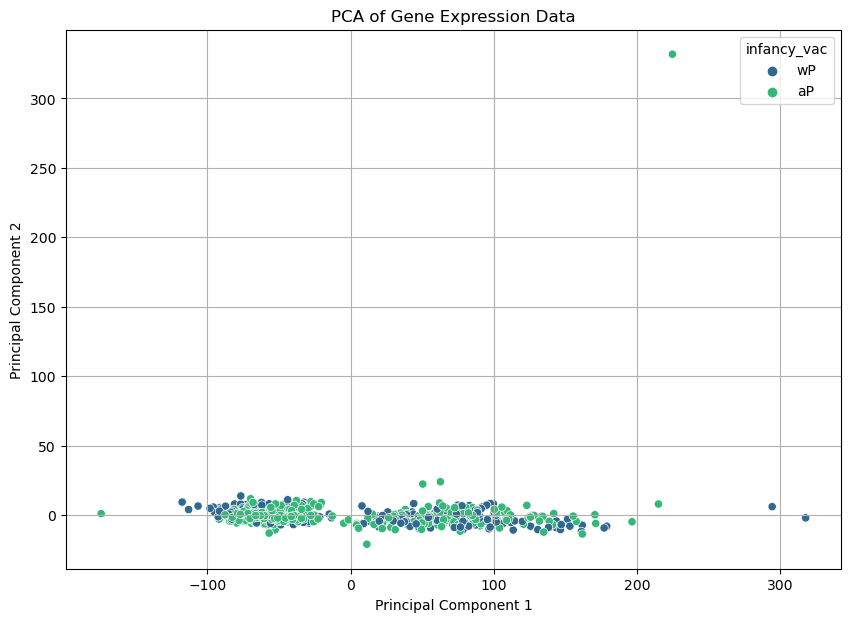

In [17]:
# Select only the gene expression columns
gene_columns = normalized_data.columns[normalized_data.columns.str.startswith('ENSG')]

# Prepare data for PCA (only include gene expression columns)
data_for_pca = normalized_data[gene_columns]

# Scale the data
scaler = StandardScaler()
scaled_data_pca = scaler.fit_transform(data_for_pca)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data_pca)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add the 'infancy_vac' column to the PCA results for visualization
pca_df['infancy_vac'] = normalized_data['infancy_vac'].values

# Explained variance
variance = pca.explained_variance_ratio_

print(f'Variance by PC1: {variance[0]:.4f}')
print(f'Variance by PC2: {variance[1]:.4f}')

# Visualize the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='infancy_vac', palette='viridis')
plt.title('PCA of Gene Expression Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

## Dimensionality Reduction with UMAP

/Users/vaishnaveethote/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


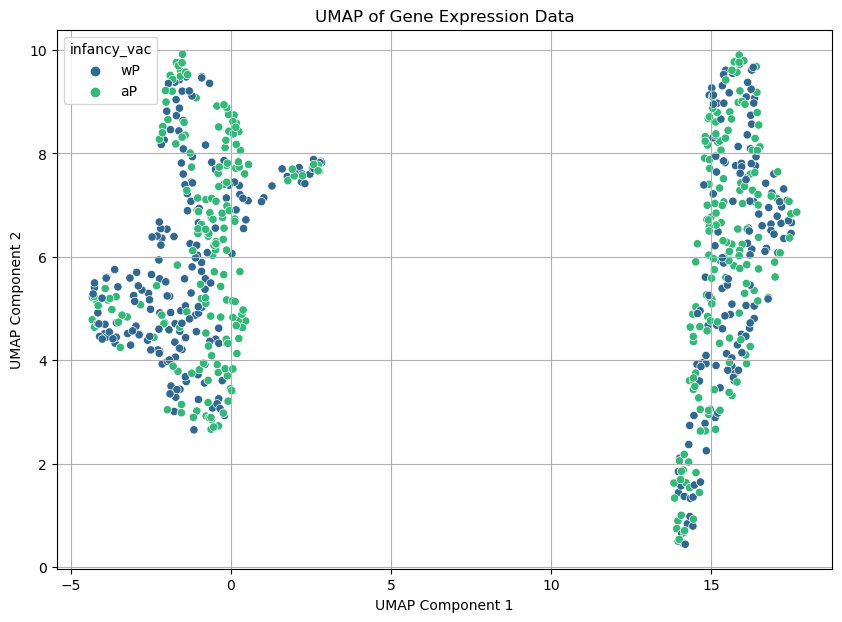

In [21]:
# Apply UMAP on the scaled PCA data
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=2, random_state=42)
umap_result = umap_model.fit_transform(scaled_data_pca)

# Create a DataFrame with the UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])

# Add the 'infancy_vac' column for visualization
umap_df['infancy_vac'] = normalized_data['infancy_vac'].values

# Visualize UMAP
plt.figure(figsize=(10, 7))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='infancy_vac', palette='viridis')
plt.title('UMAP of Gene Expression Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid()
plt.show()

## Differential Gene Expression

In [23]:
# Separate aP and wP samples based on the 'infancy_vac' column
ap_samples = normalized_data[normalized_data['infancy_vac'] == 'aP'].drop('infancy_vac', axis=1)
wp_samples = normalized_data[normalized_data['infancy_vac'] == 'wP'].drop('infancy_vac', axis=1)

# Select only numeric columns for gene expression analysis
gene_columns = ap_samples.select_dtypes(include=['number']).columns

# Subset the data to include only the gene columns
ap_samples = ap_samples[gene_columns]
wp_samples = wp_samples[gene_columns]

# Calculating mean expression for each gene in aP and wP samples
ap_mean = ap_samples.mean(axis=0)
wp_mean = wp_samples.mean(axis=0)

# T-tests for each gene
p_values = []
t_statistics = []

for gene in ap_samples.columns:
    t_stat, p_val = stats.ttest_ind(ap_samples[gene], wp_samples[gene], equal_var=False)
    t_statistics.append(t_stat)
    p_values.append(p_val)
    
# Adjust for multiple testing (Benjamini-Hochberg correction)
adjusted_p_values = smm.multipletests(p_values, method='fdr_bh')[1]

# Create a DataFrame with results
results = pd.DataFrame({
    'Gene': ap_samples.columns,
    'T-stat': t_statistics,
    'P-value': p_values,
    'Adjusted P-value': adjusted_p_values
})

# Filter significant genes based on adjusted p-value
significant_genes = results[results['Adjusted P-value'] < 0.05].copy()

# Calculating log2 fold change (log2FC)
ap_mean_clipped = ap_mean.clip(lower=1e-9)
wp_mean_clipped = wp_mean.clip(lower=1e-9)
log2_fold_change = np.log2(ap_mean_clipped / wp_mean_clipped)

# Add log2 fold change to the results
significant_genes['Log2FoldChange'] = log2_fold_change.loc[significant_genes['Gene']].values

# Sort by log2 fold change
significant_genes = significant_genes.sort_values('Log2FoldChange', ascending=False)

# Display the results
print(significant_genes)

                    Gene    T-stat       P-value  Adjusted P-value  \
1153  ENSG00000100721.10  3.984602  7.508608e-05          0.007569   
2953  ENSG00000132465.10  3.086886  2.106955e-03          0.048842   
0             subject_id  4.193965  3.139345e-05          0.004522   
4974  ENSG00000167565.12 -3.088652  2.128824e-03          0.049177   
2794  ENSG00000130066.16 -3.078738  2.164559e-03          0.049658   
...                  ...       ...           ...               ...   
5389  ENSG00000173276.13 -5.386553  1.000136e-07          0.000133   
4145  ENSG00000153234.13 -5.437070  7.618063e-08          0.000127   
5543  ENSG00000176845.12 -5.524444  4.749585e-08          0.000105   
1929   ENSG00000113070.7 -5.585417  3.690284e-08          0.000105   
534   ENSG00000069702.10 -5.541940  4.324162e-08          0.000105   

      Log2FoldChange  
1153       27.154577  
2953       26.795102  
0           0.247348  
4974      -26.836878  
2794      -26.851835  
...              ... 

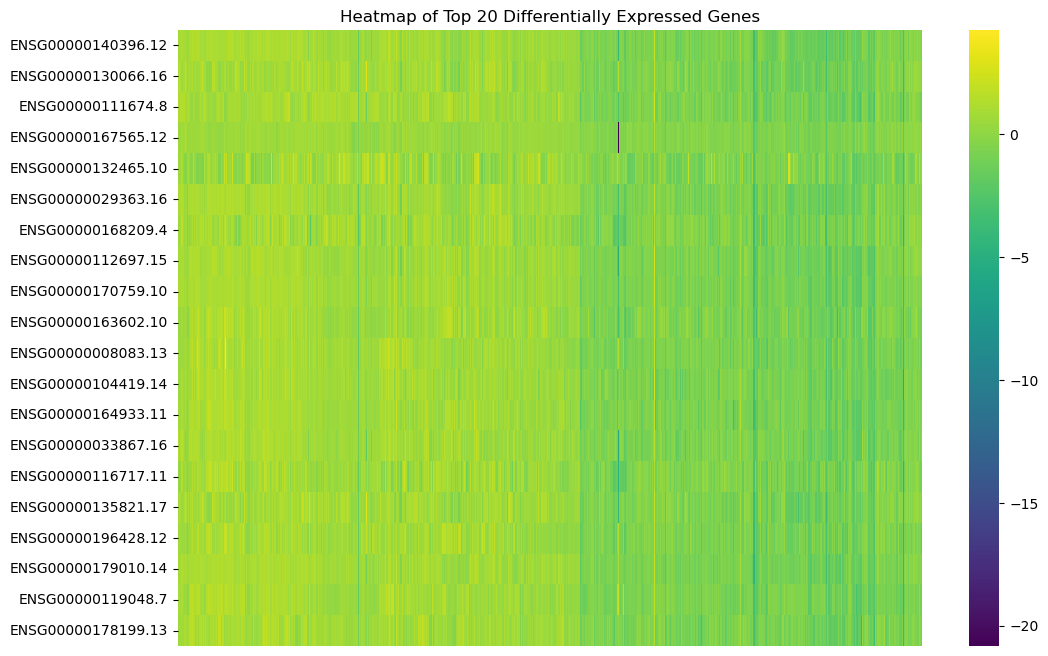

3527    ENSG00000140396.12
2794    ENSG00000130066.16
1843     ENSG00000111674.8
4974    ENSG00000167565.12
2953    ENSG00000132465.10
238     ENSG00000029363.16
5033     ENSG00000168209.4
1913    ENSG00000112697.15
5214    ENSG00000170759.10
4629    ENSG00000163602.10
93      ENSG00000008083.13
1383    ENSG00000104419.14
4763    ENSG00000164933.11
258     ENSG00000033867.16
2164    ENSG00000116717.11
3171    ENSG00000135821.17
6104    ENSG00000196428.12
5643    ENSG00000179010.14
2282     ENSG00000119048.7
5609    ENSG00000178199.13
Name: Gene, dtype: object


In [25]:
# Visualization - Heatmap 
top_genes = significant_genes.nlargest(20, 'Adjusted P-value')['Gene']  #top 20 genes 
top_gene_data = normalized_data[top_genes]

plt.figure(figsize=(12, 8))
sns.heatmap(top_gene_data.T, cmap='viridis', xticklabels=False, yticklabels=top_genes)
plt.title('Heatmap of Top 20 Differentially Expressed Genes')
plt.show()

print(top_genes)

## 6. Clustering

#### (i) k-means clustering

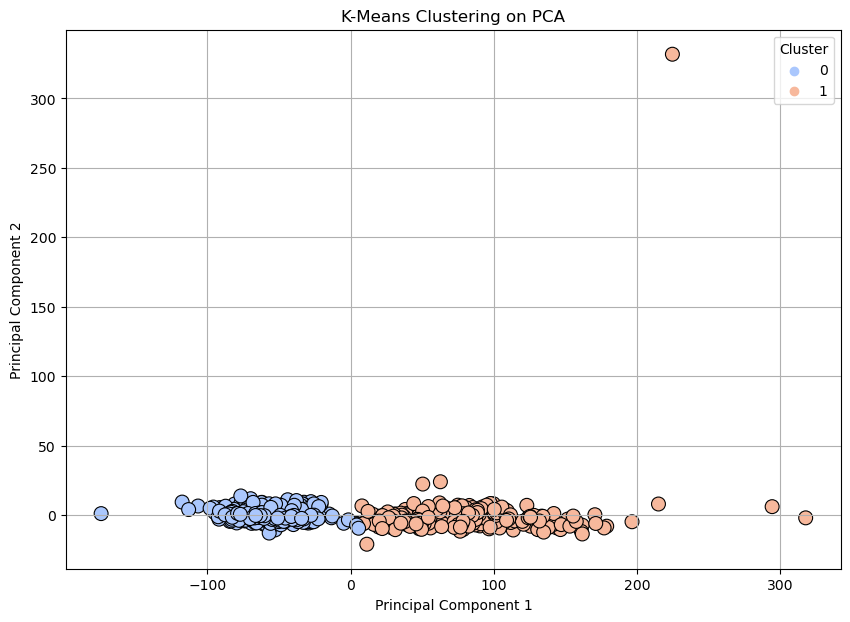

In [26]:
# Apply KMeans clustering on the PCA results
kmeans_pca = KMeans(n_clusters=2, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_result)

# Add the KMeans cluster labels to the PCA DataFrame
pca_df['Cluster'] = kmeans_pca_labels

# Visualize the clusters in PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='coolwarm', s=100, edgecolor='k')
plt.title('K-Means Clustering on PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

#### (ii) Hierarchial Clustering

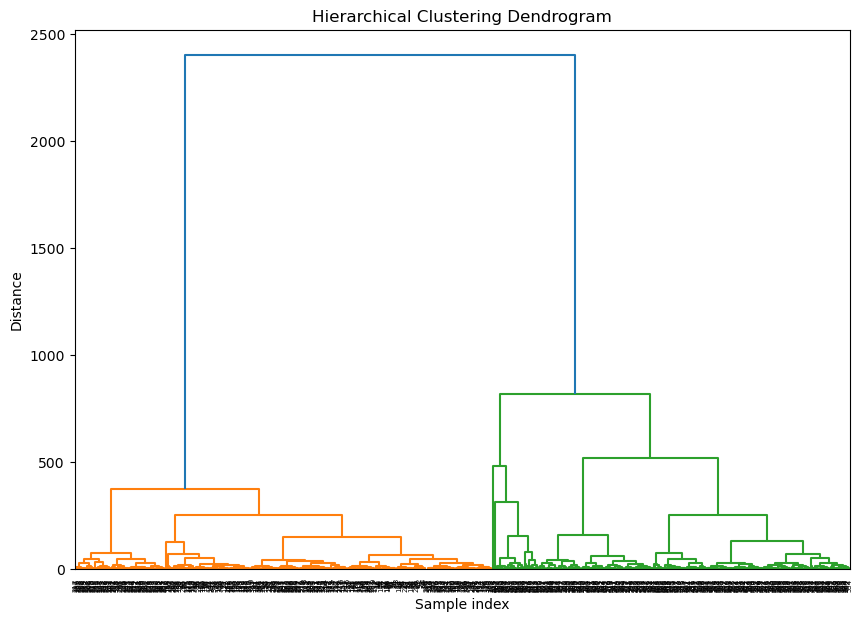

In [27]:
# Compute the linkage matrix
Z = sch.linkage(pca_result, method='ward')

# Create a dendrogram
plt.figure(figsize=(10, 7))
sch.dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

## 7. Logistic Regression

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best Logistic Regression Accuracy: 0.6055
Accuracy: 0.6343
F1 Score: 0.6202
AUC-ROC Score: 0.6664
Classification Report:
               precision    recall  f1-score   support

          aP       0.63      0.61      0.62        66
          wP       0.63      0.66      0.65        68

    accuracy                           0.63       134
   macro avg       0.63      0.63      0.63       134
weighted avg       0.63      0.63      0.63       134



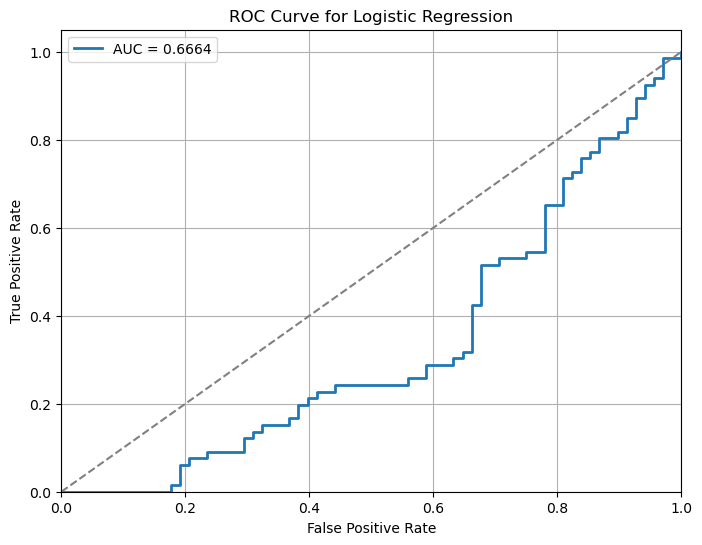

In [44]:
X = normalized_data[top_genes]  # Gene Expression levels (features)
y = normalized_data['infancy_vac']  # Vaccination type (target variable)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the logistic regression model
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Define the refined parameter grid for GridSearchCV
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1], 'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1], 'solver': ['lbfgs', 'liblinear']},
]

# Initialize GridSearchCV
grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search_log_reg.fit(X_train_scaled, y_train)

# Get the best model
best_log_reg = grid_search_log_reg.best_estimator_

# Predict on the test set
y_pred_log_reg = best_log_reg.predict(X_test_scaled)
y_probs_log_reg = best_log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg, pos_label='aP')  # Adjust pos_label if needed
roc_auc_log_reg = roc_auc_score(y_test, y_probs_log_reg)

# Print results
print("Best parameters: ", grid_search_log_reg.best_params_)
print("Best Logistic Regression Accuracy: {:.4f}".format(grid_search_log_reg.best_score_))
print("Accuracy: {:.4f}".format(accuracy_log_reg))
print("F1 Score: {:.4f}".format(f1_log_reg))
print("AUC-ROC Score: {:.4f}".format(roc_auc_log_reg))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_log_reg))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_log_reg, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_log_reg:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

## 8. Support Vector Machine

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best SVM Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best SVM Accuracy: 0.6579615588079702
Accuracy: 0.7239
F1 Score: 0.6891
AUC-ROC Score: 0.7938
Classification Report:
               precision    recall  f1-score   support

          aP       0.77      0.62      0.69        66
          wP       0.69      0.82      0.75        68

    accuracy                           0.72       134
   macro avg       0.73      0.72      0.72       134
weighted avg       0.73      0.72      0.72       134



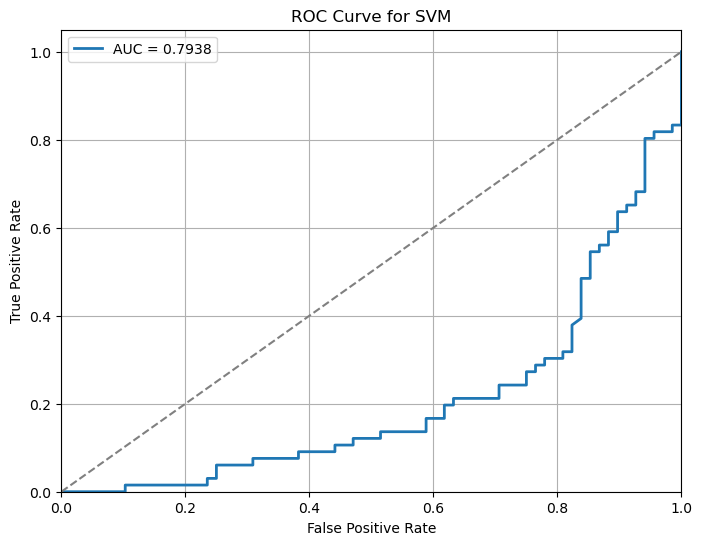

In [45]:
# SVM hyperparameter grid
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'poly', 'linear']
}

# GridSearchCV for SVM
svm_grid_search = GridSearchCV(
    estimator=SVC(random_state=42, probability=True),
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)
svm_grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_svm = svm_grid_search.best_estimator_

# Predict on the test set
y_pred_svm = best_svm.predict(X_test_scaled)
y_probs_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm, pos_label='aP')  # Adjust pos_label if needed
roc_auc_svm = roc_auc_score(y_test, y_probs_svm)

# Best parameters and accuracy
print("Best SVM Parameters:", svm_grid_search.best_params_)
print("Best SVM Accuracy:", svm_grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_svm))
print("F1 Score: {:.4f}".format(f1_svm))
print("AUC-ROC Score: {:.4f}".format(roc_auc_svm))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_svm, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_svm:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for SVM")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

## 9. Random Forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest Accuracy: 0.6635690354434844
Accuracy: 0.7090
F1 Score: 0.7023
AUC-ROC Score: 0.7645
Classification Report:
               precision    recall  f1-score   support

          aP       0.71      0.70      0.70        66
          wP       0.71      0.72      0.72        68

    accuracy                           0.71       134
   macro avg       0.71      0.71      0.71       134
weighted avg       0.71      0.71      0.71       134



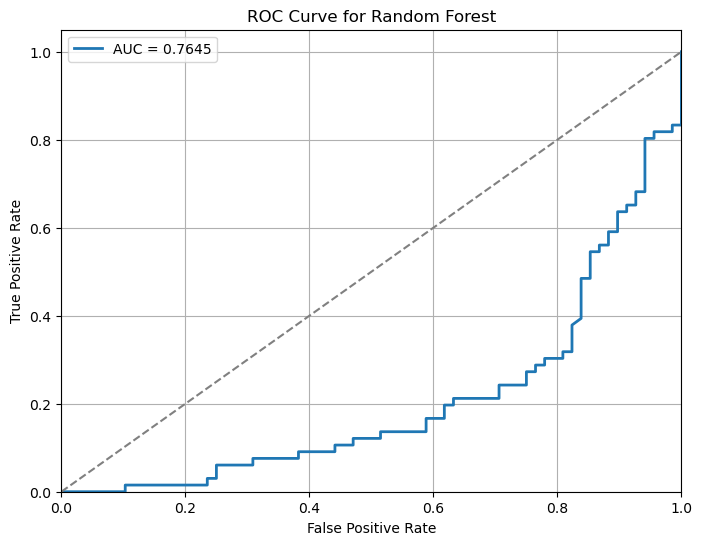

In [46]:
# Random Forest hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)
rf_grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_rf = rf_grid_search.best_estimator_

# Predict on the test set
y_pred_rf = best_rf.predict(X_test_scaled)
y_probs_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, pos_label='aP')  
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# Best parameters and accuracy
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest Accuracy:", rf_grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_rf))
print("F1 Score: {:.4f}".format(f1_rf))
print("AUC-ROC Score: {:.4f}".format(roc_auc_rf))

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# ROC Curve
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_probs_rf, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_rf:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Random Forest")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

## 10. XGBoost

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best XGBoost Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
Best XGBoost Accuracy: 0.6748016222888379
Accuracy: 0.6866
F1 Score: 0.6866
AUC-ROC Score: 0.7382
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69        66
           1       0.70      0.68      0.69        68

    accuracy                           0.69       134
   macro avg       0.69      0.69      0.69       134
weighted avg       0.69      0.69      0.69       134



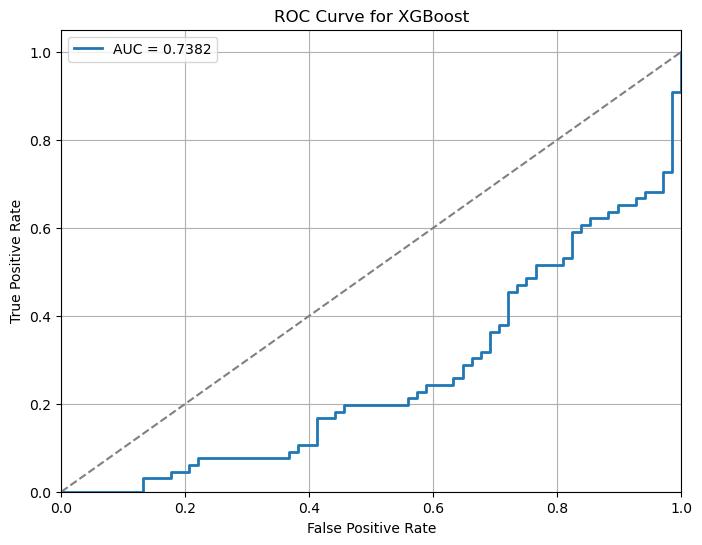

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=10, gamma=0.1, kernel=poly; total time=   0.4s
[CV] END .....................C=10, gamma=0.1, kernel=linear; total time=   0.2s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   2.9s
[CV] END max_depth=None, min

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.1s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.9s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.2s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.3s
[CV] END .......................C=10, gamma=1, kernel=linear; total time=   0.3s
[CV] END ...................

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ....................C=1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................

In [47]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Apply encoding on y_train
y_test_encoded = label_encoder.transform(y_test)        # Apply encoding on y_test

# Define the XGBoost model
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",  
    verbosity=0            
)

# Define parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200, 300],   
    "max_depth": [3, 5, 7],             
    "learning_rate": [0.01, 0.05, 0.1, 0.2],   
    "subsample": [0.6, 0.8, 1.0],              
    "colsample_bytree": [0.6]        
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train_encoded)

# Get the best model
best_xgb = grid_search.best_estimator_

# Predict on the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_probs_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Compute accuracy, F1-score, and AUC-ROC score
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, pos_label=label_encoder.transform(['aP'])[0])  # Adjust 'aP' if needed
roc_auc_xgb = roc_auc_score(y_test_encoded, y_probs_xgb)

# Best parameters and accuracy
print("Best XGBoost Parameters:", grid_search.best_params_)
print("Best XGBoost Accuracy:", grid_search.best_score_)
print("Accuracy: {:.4f}".format(accuracy_xgb))
print("F1 Score: {:.4f}".format(f1_xgb))
print("AUC-ROC Score: {:.4f}".format(roc_auc_xgb))

# Print classification report
print("Classification Report:\n", classification_report(y_test_encoded, y_pred_xgb))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb, pos_label='aP')
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc_xgb:.4f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [32]:
# Encode the target variable
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # 'aP' -> 1, 'wP' -> 0


In [33]:
# Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_probs_log_reg, pos_label='aP')
roc_auc_log_reg = roc_auc_score(y_test, y_probs_log_reg)

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm, pos_label='aP')
roc_auc_svm = roc_auc_score(y_test, y_probs_svm)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf, pos_label='aP')
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

# XGBoost
fpr, tpr, _ = roc_curve(y_test, y_probs_xgb, pos_label='aP')
roc_auc_xgb = roc_auc_score(y_test, y_probs_xgb)

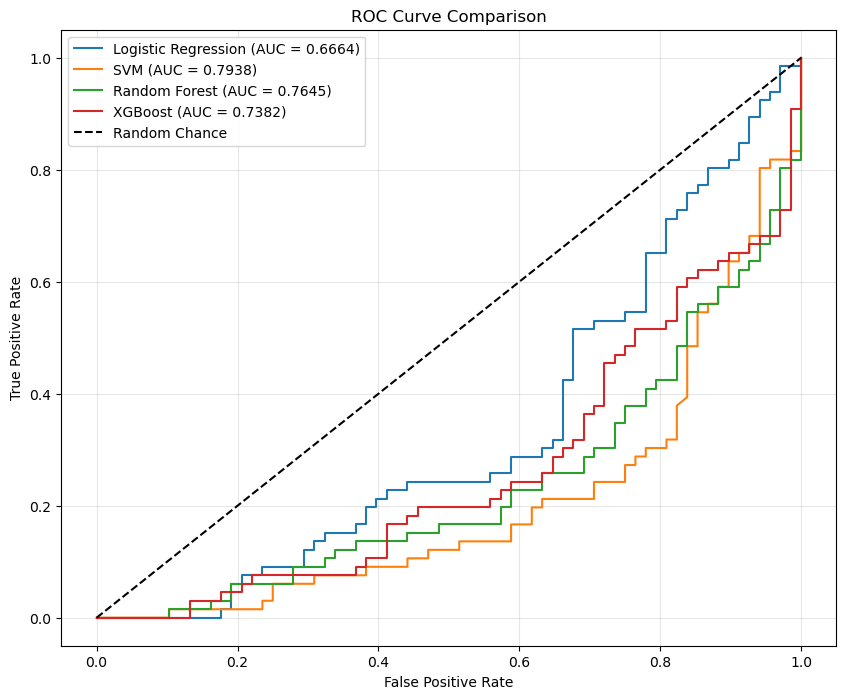

In [34]:
# Plot all ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_log_reg, tpr_log_reg, label=f"Logistic Regression (AUC = {roc_auc_log_reg:.4f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})")

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Add plot details
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()

## 11. Feature Importance

feature importance will provide insights into which antibodies are most predictive of the target variable.

### Random Forest

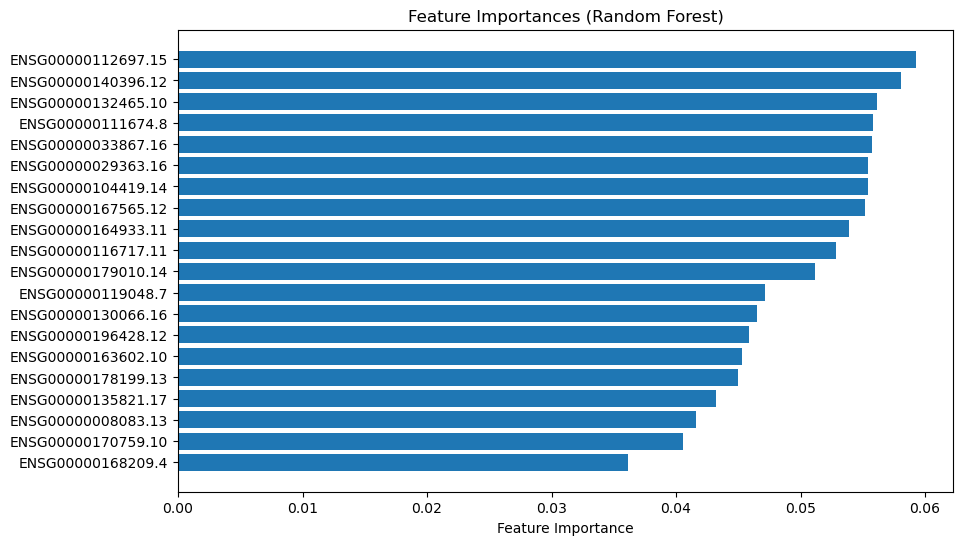

In [48]:
# Get the best XGBoost model
best_rf = grid_search.best_estimator_

# Get feature importances
importances_rf = best_rf.feature_importances_

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort feature importances in descending order
sorted_idx_rf = importances_rf.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in sorted_idx_rf], 
    importances_rf[sorted_idx_rf], 
    align='center'
)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (Random Forest)')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

### XGBoost

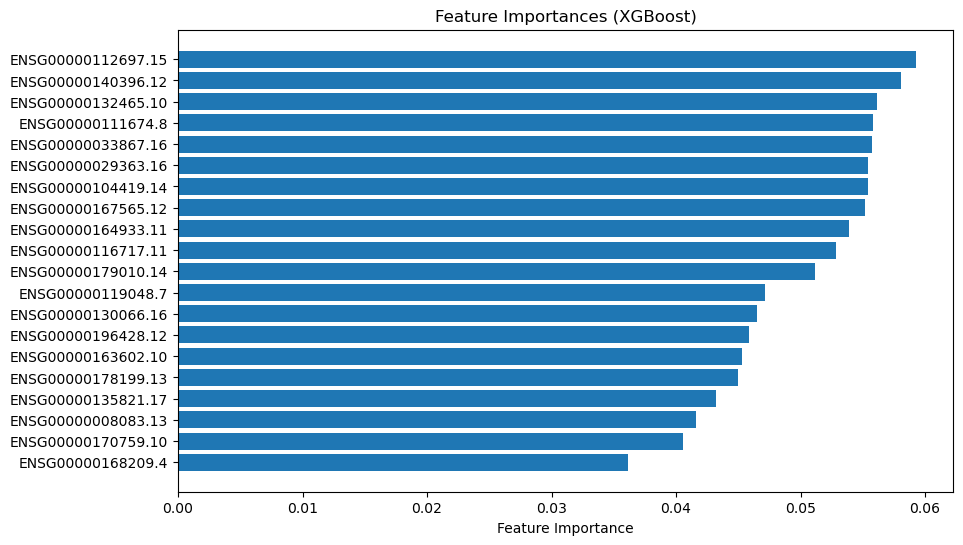

In [37]:
# Get the best XGBoost model
best_gb = grid_search.best_estimator_

# Get feature importances
importances_gb = best_gb.feature_importances_

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Sort feature importances in descending order
sorted_idx_gb = importances_gb.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in sorted_idx_gb], 
    importances_gb[sorted_idx_gb], 
    align='center'
)
plt.xlabel('Feature Importance')
plt.title('Feature Importances (XGBoost)')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()

### Support Vector Machine

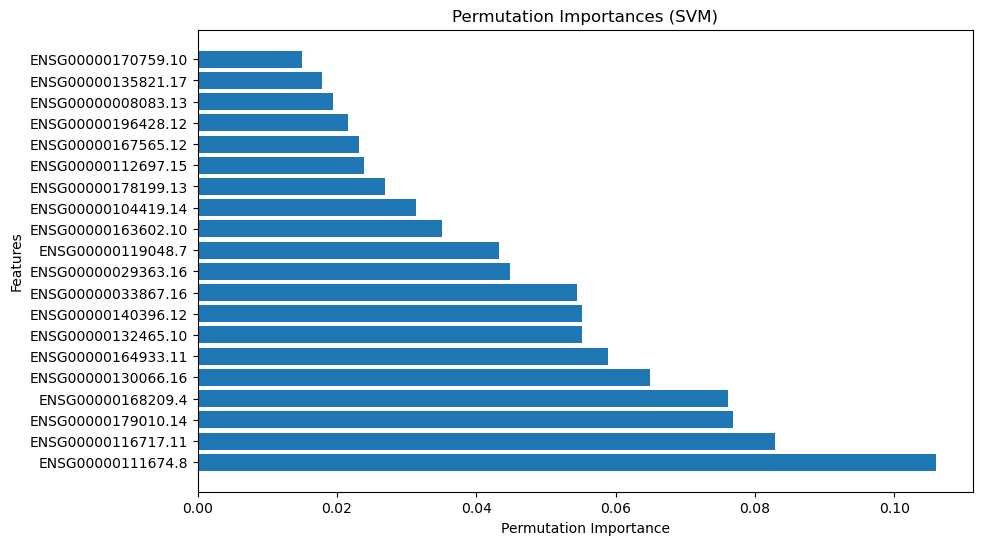

In [39]:
# Get the best model from GridSearchCV
best_svm = svm_grid_search.best_estimator_

# Compute permutation importances
result = permutation_importance(best_svm, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances = result.importances_mean

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx = np.argsort(importances)[::-1]

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importances (SVM)')
plt.show()

### Logistic Regression

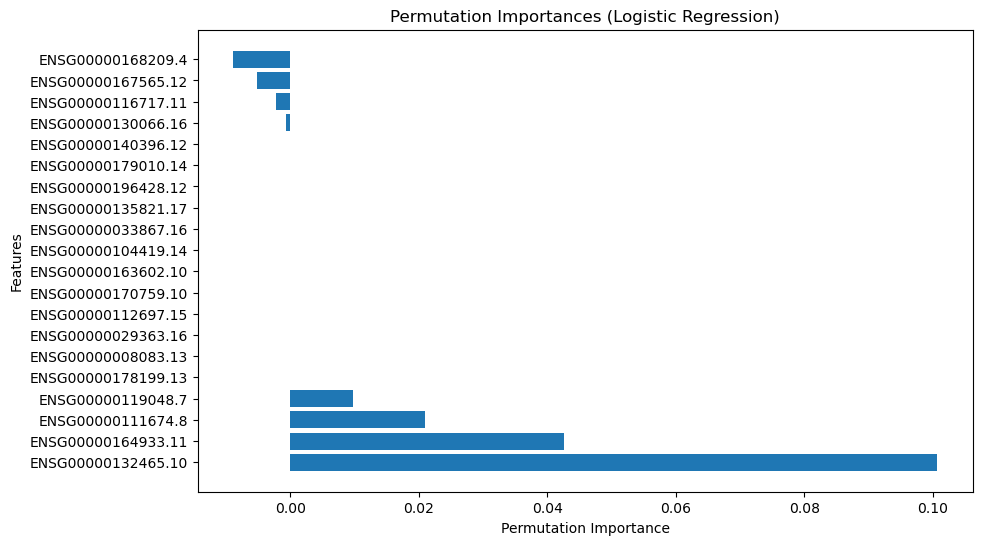

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.5s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.5s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; tot

In [40]:
# Get the best model from GridSearchCV
best_log_reg = grid_search_log_reg.best_estimator_

# Compute permutation importances
result_log_reg = permutation_importance(best_log_reg, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='accuracy')
importances_log_reg = result_log_reg.importances_mean

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx_log_reg = np.argsort(importances_log_reg)[::-1]

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx_log_reg], importances_log_reg[sorted_idx_log_reg], align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Importances (Logistic Regression)')
plt.show()